In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# 设置中文字体，解决中文乱码问题
plt.rcParams['font.sans-serif'] = ['SimHei', 'Microsoft YaHei', 'DejaVu Sans']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号

In [3]:
def cv2_imshow(img, gray=False, title=None):

    if len(img.shape) == 3 and img.shape[2] == 3:
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.imshow(img_rgb)
    else:
        plt.imshow(img, cmap='gray')
    plt.title(title, fontsize=12, fontweight='bold')
    plt.tight_layout()

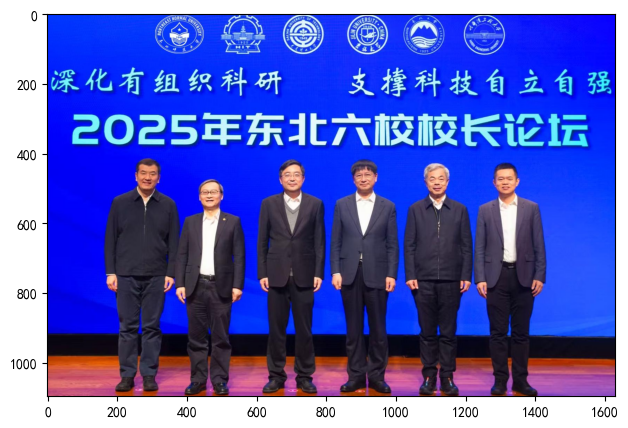

In [4]:
image_path = "1.jpg"
img = cv2.imread(image_path)
cv2_imshow(img)
img_for_hog = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) 

In [5]:
patch_x_start, patch_x_end = 600,800
patch_y_start, patch_y_end = 400,1000
block_size = 2
cell_size = 16  
nbins = 9  

In [6]:
patch_img = img[patch_y_start:patch_y_end, patch_x_start:patch_x_end]
patch_gray = img_for_hog[patch_y_start:patch_y_end, patch_x_start:patch_x_end]
patch_height, patch_width = patch_gray.shape

# 计算图像梯度

In [7]:
patch_grad_x = cv2.Sobel(patch_gray, cv2.CV_64F, 1, 0, ksize=3)
patch_grad_y = cv2.Sobel(patch_gray, cv2.CV_64F, 0, 1, ksize=3)
patch_magnitude = np.sqrt(patch_grad_x**2 + patch_grad_y**2)
patch_angle = np.arctan2(patch_grad_y, patch_grad_x) * 180 / np.pi
patch_angle = np.where(patch_angle < 0, patch_angle + 180, patch_angle)

# 以16x16的cell为单位计算梯度直方图

In [8]:
patch_h, patch_w = patch_gray.shape
patch_n_cells_y = patch_h // cell_size
patch_n_cells_x = patch_w // cell_size
patch_histogram = np.zeros((patch_n_cells_y, patch_n_cells_x, nbins))

for i in range(patch_n_cells_y):
    for j in range(patch_n_cells_x):
        y_start = i * cell_size
        y_end = y_start + cell_size
        x_start = j * cell_size
        x_end = x_start + cell_size
        
        cell_magnitude = patch_magnitude[y_start:y_end, x_start:x_end]
        cell_angle = patch_angle[y_start:y_end, x_start:x_end]
        
        bin_width = 20.0
        for y in range(cell_size):
            for x in range(cell_size):
                mag = cell_magnitude[y, x]
                ang = cell_angle[y, x]
                center_bin = ang / bin_width
                bin_idx0 = int(center_bin) % nbins
                bin_idx1 = (bin_idx0 + 1) % nbins
                weight1 = center_bin - int(center_bin)
                weight0 = 1.0 - weight1
                patch_histogram[i, j, bin_idx0] += mag * weight0
                patch_histogram[i, j, bin_idx1] += mag * weight1

# 以block进行归一化

In [9]:
patch_n_blocks_y = patch_n_cells_y - block_size + 1
patch_n_blocks_x = patch_n_cells_x - block_size + 1
patch_hog_features = []

for i in range(patch_n_blocks_y):
    for j in range(patch_n_blocks_x):
        block_hist = patch_histogram[i:i+block_size, j:j+block_size, :]
        block_vector = block_hist.flatten()
        norm = np.linalg.norm(block_vector)
        if norm > 0:
            block_vector_normalized = block_vector / norm
        else:
            block_vector_normalized = block_vector
        patch_hog_features.append(block_vector_normalized)

# 将所有block归一化后的梯度直方图组合成HOG特征向量

In [10]:
patch_hog_feature_vector = np.concatenate(patch_hog_features)

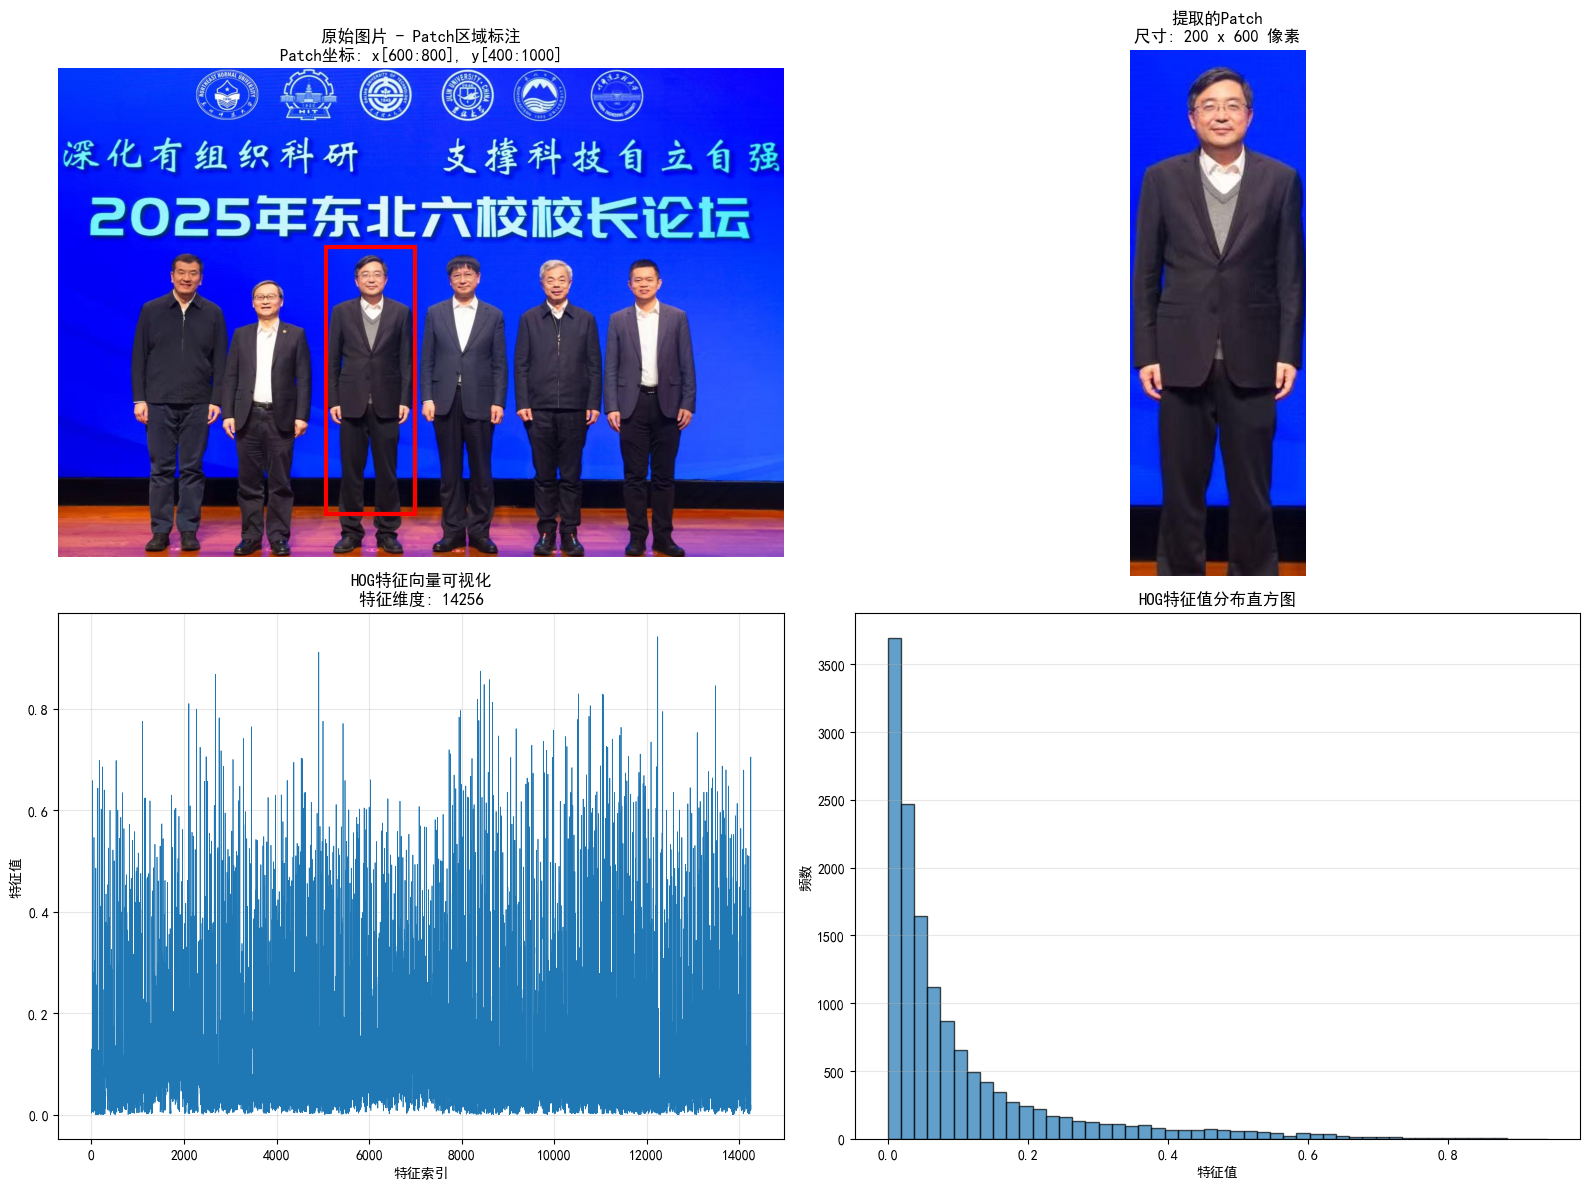

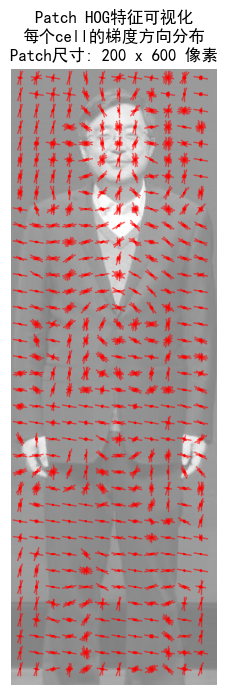

In [11]:
# 创建可视化图像
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. 显示原始图片并标注patch区域
axes[0, 0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
# 绘制patch区域的矩形框
rect = plt.Rectangle((patch_x_start, patch_y_start), 
                    patch_x_end - patch_x_start, 
                    patch_y_end - patch_y_start,
                    linewidth=3, edgecolor='red', facecolor='none')
axes[0, 0].add_patch(rect)
axes[0, 0].set_title(f'原始图片 - Patch区域标注\nPatch坐标: x[{patch_x_start}:{patch_x_end}], y[{patch_y_start}:{patch_y_end}]', 
                     fontsize=12, fontweight='bold')
axes[0, 0].axis('off')

# 2. 显示提取的patch
axes[0, 1].imshow(cv2.cvtColor(patch_img, cv2.COLOR_BGR2RGB))
axes[0, 1].set_title(f'提取的Patch\n尺寸: {patch_width} x {patch_height} 像素', 
                   fontsize=12, fontweight='bold')
axes[0, 1].axis('off')

# 3. 可视化HOG特征向量（绘制整个特征向量的值）
axes[1, 0].plot(patch_hog_feature_vector, linewidth=0.5)
axes[1, 0].set_title(f'HOG特征向量可视化\n特征维度: {patch_hog_feature_vector.shape[0]}', 
                    fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('特征索引')
axes[1, 0].set_ylabel('特征值')
axes[1, 0].grid(True, alpha=0.3)

# 4. 可视化HOG特征的直方图统计
axes[1, 1].hist(patch_hog_feature_vector, bins=50, edgecolor='black', alpha=0.7)
axes[1, 1].set_title('HOG特征值分布直方图', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('特征值')
axes[1, 1].set_ylabel('频数')
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()

# 保存截图
output_filename = 'hog_patch_visualization.png'
plt.savefig(output_filename, dpi=150, bbox_inches='tight')

# 显示图像
plt.show()

# 额外创建一个详细的HOG特征可视化（可视化每个cell的梯度方向）
fig2, ax = plt.subplots(1, 1, figsize=(12, 8))
ax.imshow(patch_gray, cmap='gray', alpha=0.5)

# 可视化每个cell的梯度方向
cell_vis_size = 16
for i in range(patch_n_cells_y):
    for j in range(patch_n_cells_x):
        # 计算cell中心位置
        center_y = (i + 0.5) * cell_size
        center_x = (j + 0.5) * cell_size
        
        # 获取该cell的直方图
        cell_hist = patch_histogram[i, j, :]
        max_val = cell_hist.max()
        
        # 为每个bin绘制线条
        for bin_idx in range(nbins):
            if cell_hist[bin_idx] > 0:
                angle_deg = bin_idx * 20 + 10  # bin的中心角度
                angle_rad = np.deg2rad(angle_deg)
                length = cell_hist[bin_idx] / max_val * (cell_size * 0.4)
                
                dx = length * np.cos(angle_rad)
                dy = length * np.sin(angle_rad)
                
                ax.plot([center_x - dx, center_x + dx], 
                       [center_y - dy, center_y + dy],
                       'r-', linewidth=1, alpha=0.6)

ax.set_title(f'Patch HOG特征可视化\n每个cell的梯度方向分布\nPatch尺寸: {patch_width} x {patch_height} 像素', 
            fontsize=12, fontweight='bold')
ax.axis('off')

output_filename2 = 'hog_patch_detailed.png'
plt.savefig(output_filename2, dpi=150, bbox_inches='tight')
plt.show()